In [1]:
import numpy as np
import os
import json
import argparse

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Activation, Embedding

2023-02-04 12:27:58.981861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 12:27:59.978721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-04 12:27:59.978756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-04 12:28:03.492738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
with open("./input.txt") as f:
    input_text = f.read()
char_to_idx = {ch: i for (i, ch) in enumerate(sorted(list(set(input_text))))}
idx_to_char = {i: ch for (ch, i) in char_to_idx.items()}

vocab_size = len(char_to_idx)
T = np.asarray([char_to_idx[c] for c in input_text], dtype=np.int32)

In [4]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

In [5]:
def read_batches(T, BATCH_SIZE):
    NUM_CHAR_EACH_ROW = T.shape[0]//BATCH_SIZE
    
    for start in range(0, NUM_CHAR_EACH_ROW - SEQ_LENGTH, SEQ_LENGTH):
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH))
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size))
        for row in range(16):
            for col in range(64):
                X[row, col] = T[row*NUM_CHAR_EACH_ROW + start + col]
                Y[row, col, T[row*NUM_CHAR_EACH_ROW + start + col + 1]] = 1
        yield X , Y

In [67]:
MODEL_DIR = "./Model_torch_weights"

In [8]:
def build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(BATCH_SIZE, SEQ_LENGTH)))
    for i in range(3):
        model.add(LSTM(256, return_sequences= True, stateful=True))
        model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(vocab_size)))
    model.add(Activation("softmax"))
    return model
def save_weights(model, epoch):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, f"weights.{epoch}.h5"))
def load_weights(model, epoch):
    model.load_weights(os.path.join(MODEL_DIR, f"weights.{epoch}.h5"))
    return model

In [9]:
model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

2023-02-04 12:41:46.877545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-04 12:41:46.878696: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-04 12:41:46.878769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-02-04 12:41:46.880386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
load_weights(model, 80)

In [ ]:
epochs = 100
save_freq = 20
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    losses, accs = [], []

    for i, (X, Y) in enumerate(read_batches(T, BATCH_SIZE)):

        loss, acc = model.train_on_batch(X, Y)
        print(f'Batch {i+1}: loss = {loss}, acc = {acc}')
        losses.append(loss)
        accs.append(acc)

    # log.add_entry(np.average(losses), np.average(accs))

    if (epoch + 1) % save_freq == 0:
        save_weights(model, epoch + 1)
        print('Saved checkpoint to', f'weights.{epoch+1}.h5')


Epoch 1/100
Batch 1: loss = 4.4547119140625, acc = 0.013671875
Batch 2: loss = 4.43332576751709, acc = 0.1259765625
Batch 3: loss = 4.385631561279297, acc = 0.1142578125
Batch 4: loss = 4.174156665802002, acc = 0.1455078125
Batch 5: loss = 3.715034246444702, acc = 0.1611328125
Batch 6: loss = 3.813836097717285, acc = 0.142578125
Batch 7: loss = 3.6775920391082764, acc = 0.1298828125
Batch 8: loss = 3.62931489944458, acc = 0.0732421875
Batch 9: loss = 3.704057216644287, acc = 0.0732421875
Batch 10: loss = 3.6648497581481934, acc = 0.0654296875
Batch 11: loss = 3.4651412963867188, acc = 0.0947265625
Batch 12: loss = 3.478306770324707, acc = 0.1455078125
Batch 13: loss = 3.5541069507598877, acc = 0.140625
Batch 14: loss = 3.5442323684692383, acc = 0.150390625
Batch 15: loss = 3.580540657043457, acc = 0.1357421875
Batch 16: loss = 3.4498682022094727, acc = 0.1552734375
Batch 17: loss = 3.3879833221435547, acc = 0.166015625
Batch 18: loss = 3.341151475906372, acc = 0.162109375
Batch 19: lo

In [12]:
np.average(losses), np.average(accs)

(0.2470465495236336, 0.9164574032738095)

In [14]:
def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

In [15]:
model = build_sample_model(vocab_size)

In [16]:
model = load_weights(model, 100)

In [21]:
batch = np.zeros((1,1))
batch[0, 0] = np.random.randint(86)

In [22]:
result = model.predict_on_batch(batch).ravel()

In [23]:
sample = np.random.choice(range(vocab_size), p=result)

In [19]:
num_chars = 1000
sampled = []
for i in range(num_chars):
    batch = np.zeros((1, 1))
    if sampled:
        batch[0, 0] = sampled[-1]
    else:
        batch[0, 0] = np.random.randint(vocab_size)
    result = model.predict_on_batch(batch).ravel()
    sample = np.random.choice(range(vocab_size), p=result)
    sampled.append(sample)

In [20]:
print(''.join(idx_to_char[c] for c in sampled))

:"B7"d2c "F#7"e2c|"Bm"dcB "E7"B2G|
"A"A2B c2d|"A"eab "E7"ega|"A"aec A2e|
"A"fed c2A|"E"GB2 e3|"E7"efe dcB|"A"A3 -A2:|


X: 101
T:Garster Jig
% Nottingham Music Database
S:Chris Dewhurst 1980, via Phil Rowe
M:6/8
K:G
G2A |"G"B2B BAG|"B"A2A AGF|"C"G2G GAB|"G"D2B "G7"c2d|"C"e3 "G7"ed^c|\
"G"B2c dBd|
"C"e2c "C7"GAG|"F"A2A "G7"GAB|"C"c2c edc|"G"B2G G2B|
"C"cdc efg|"D7"FGA AGF| [1"F"fAF "C"GEC||


X: 300
T:Jown Lagactsire
% Nottingham Music Database
S:Ganfs MacKay, via EF
M:6/8
K:A
P:A
|:e|"A"agf "E7"efg|"A"aga f2e|"D"fed "A"cde|
"D"F2A "A"ABc|"Bm/2"d2B "E7/g+"c2B|"A"c3 "A7/e"c3|\
"D"d2d "A"e2d|\
"D/f+"d3 "G"d2:|
P:B
c/2d/2|"A"e2e c2e|"D"f2f f3|"E7"gfg gfe|"A"a3 "D#m"a2f|
"G"gab "D"afd|"A"ecA gfe|"Bm"efe "E7"dcB|"A"A3 A2:|


X: 229
T:Male's Jig
% Nottingham Music Database
Y:AABBCC
S:Folk Camp, via EF
M:6/8
K:D
P:A
|:F/2G/2|"D"A2D FED|"G"D2D D2B|"A7"ABc "D"d2A|"Bm"Bcd "Em"GBB|
"C"cBc edc|"G"BcB "D7"cBA|"G"GAG "Am"AGA|"D7"FGA "G"G3:|


X: 257
T:Moddaber Mack
% Nottingham Music Database
S:FTB, 

In [2]:
!nvidia-smi

Sat Feb  4 07:28:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   22C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Pytorch Version

In [13]:
import numpy as np
import re
import random 
import pickle
import itertools
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
with open("./input.txt") as f:
    input_text = f.read()
char_to_idx = {ch: i for (i, ch) in enumerate(sorted(list(set(input_text))))}
idx_to_char = {i: ch for (ch, i) in char_to_idx.items()}

vocab_size = len(char_to_idx)
T = torch.tensor([char_to_idx[c] for c in input_text], dtype=torch.int32)

In [3]:
BATCH_SIZE = 16
SEQ_LENGTH = 64

In [4]:
def read_batches(T, BATCH_SIZE):
    NUM_CHAR_EACH_ROW = T.shape[0]//BATCH_SIZE
    
    for start in range(0, NUM_CHAR_EACH_ROW - SEQ_LENGTH, SEQ_LENGTH):
        X = torch.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=torch.int32)
        Y = torch.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size))
        for row in range(16):
            for col in range(64):
                X[row, col] = T[row*NUM_CHAR_EACH_ROW + start + col]
                Y[row, col, T[row*NUM_CHAR_EACH_ROW + start + col + 1]] = 1
        yield X , Y

In [37]:
class CharLSTM(nn.Module):
    def __init__(self, n_hidden = 256, n_layers = 3, drop_prob = 0.2):
        super(CharLSTM, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        self.emb = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(512, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, x, h):
        embedded = self.emb(x)
        out, hn = self.lstm(embedded, h)
        out = self.dropout(out)
        out = out.reshape(-1, self.n_hidden)
        out = self.fc(out)
        
        return out, hn
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)

        return (h0,c0)

In [6]:
MODEL_DIR = "./Model_torch_weights"
def save_weights(model, epoch):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, f"weights.{epoch}.pt"))
def load_weights(model, epoch):
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"weights.{epoch}.pt")))
    model.eval()
    return model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [78]:
model = CharLSTM().to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
save_freq = 20
tr_loss = []
model.train()

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    epoch_loss = 0
    h = model.init_hidden(BATCH_SIZE)
    for idx, (X,Y) in enumerate(read_batches(T, BATCH_SIZE)):
        x = X.to(device)
        y = Y.view(-1, 86).to(device)
        
        outputs, h = model(x, h)
        loss = criterion(outputs, y)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        h = (h[0].detach(), h[1].detach())
        
        epoch_loss += loss.item()
        
        print(f"Batch {idx+1}: loss = {loss.item()}")
    
    tr_loss.append(epoch_loss)
    if (epoch+1) % save_freq == 0:
        save_weights(model, epoch+1)
        print('Saved checkpoint to', f'weights.{epoch+1}.pt')


Epoch 1/100
Batch 1: loss = 4.458819389343262
Batch 2: loss = 4.418922424316406
Batch 3: loss = 4.371307373046875
Batch 4: loss = 4.245875358581543
Batch 5: loss = 3.9554805755615234
Batch 6: loss = 3.6922225952148438
Batch 7: loss = 3.541724920272827
Batch 8: loss = 3.4940390586853027
Batch 9: loss = 3.615858554840088
Batch 10: loss = 3.5729775428771973
Batch 11: loss = 3.3902955055236816
Batch 12: loss = 3.455176591873169
Batch 13: loss = 3.5163984298706055
Batch 14: loss = 3.4540257453918457
Batch 15: loss = 3.4996345043182373
Batch 16: loss = 3.34891414642334
Batch 17: loss = 3.302205801010132
Batch 18: loss = 3.26393985748291
Batch 19: loss = 3.4526662826538086
Batch 20: loss = 3.401099681854248
Batch 21: loss = 3.4457273483276367
Batch 22: loss = 3.392259120941162
Batch 23: loss = 3.2262730598449707
Batch 24: loss = 3.369324207305908
Batch 25: loss = 3.3640048503875732
Batch 26: loss = 3.364295244216919
Batch 27: loss = 3.1230974197387695
Batch 28: loss = 3.2189364433288574
Batc

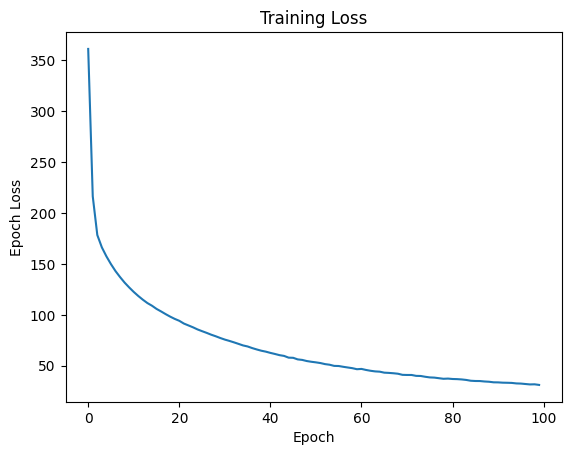

In [77]:
import matplotlib.pyplot as plt
plt.plot(np.arange(100), tr_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Epoch Loss")
plt.show()

In [74]:
import math
print(f"Perplexity: {math.pow(2, tr_loss[-1])}")

Perplexity: 2494051370.8386993


In [38]:
model = CharLSTM()
model = load_weights(model, 100)

In [39]:
model.to(device)

CharLSTM(
  (emb): Embedding(86, 512)
  (lstm): LSTM(512, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=86, bias=True)
)

In [70]:
num_chars = 2000
sampled = []
h = model.init_hidden(1)
for i in range(num_chars):
    batch = torch.zeros((1, 1))
    if sampled:
        batch[0, 0] = sampled[-1]
    else:
        batch[0, 0] = torch.randint(0, vocab_size, (1,))
    batch = batch.to(torch.int32)
    x = batch.to(device)
    result, h = model(x, h)
    p = nn.Softmax(dim=1)(result)
    sample = p.multinomial(num_samples=1, replacement=True)
    sampled.append(sample.item())

In [71]:
print(''.join(idx_to_char[c] for c in sampled))

 Casher
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:G
G|:"G"GBc "Em"BAG|"D7"dcA ABc|"G"BGG G2D|"G"BAG "C"G2E|"G"DGG "A7"E2G|"D7"FAG FED|
"G"GFG BAG|"D"FEF "G"GAB|"Em"AGF "Am"E2A|"Em"BGE E2:|


X: 282
T:Shafters Shindig
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:G
D|"G"G2G "D7"AGF|"G"G3 "C"g2e|"G"dBG E2D|"C"EFG "D7"AFD|"G"G3 -G2::
c|"G"B2G "D7"AFD|"G"G3 -G2B|"D7"ABc a2A|
"G"B2A G2B|"A7"A2G F2G|"D7"A3 -Adc|
"G"B3 G3|"G"D2B c2B|"Am"A2G "D7"FED|"G"G2G "D"A2A|"G"B2c dBc|\
"D7"cBA "G"G3:|


X: 303
T:Swallort
% Nottingham Music Database
Y:AABB
S:John Lagden, via EF
M:6/8
K:G
P:A
|:B/2c/2|"G"d2d "C"c2e|"G"dBG GAB|"Em"E3 E2:|
P:B
B/2c/2|"G"ded "D7"c2A|"G"BGG DGG|"G"BGB dcB|"C"cAG "D7"AFA|
"G"GBc "G"DGB|"C"cdc "G"BAG|"D7"FGA A2G|
"G"BAB GBd|"C"ece gfe|"G"d/2g3/2B "D7"dcA|"G"G3 G2:|
P:B
d/2d/2|"G"gfg "D"afd|"C"efg gfe|"G"dBg "C"ecg|"G"dcB "Em"G2:|


X: 196
T:The Lady Of The Lake
% Nottingham Music Database
S:Bob McQuillen Jan 1979, via Phil Rowe
M:6/8
K:D
"D"DFA BAF|"